In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = conv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.se = SELayer(32)
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(32*8*8, 512)
        self.fc_2 = nn.Linear(512, 3)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.se(x)

        #全結合層
        x = self.sigmoid(self.fc_1(self.flatten(x)))
        x = self.fc_2(x)
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 32, 32]          32
│    └─ReLU: 2-3                         [64, 16, 32, 32]          --
│    └─Dropout2d: 2-4                    [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 16, 16, 16]          --
├─conv2DBatchNormRelu: 1-3               [64, 32, 16, 16]          --
│    └─Conv2d: 2-5                       [64, 32, 16, 16]          4,640
│    └─BatchNorm2d: 2-6                  [64, 32, 16, 16]          64
│    └─ReLU: 2-7                         [64, 32, 16, 16]          --
│    └─Dropout2d: 2-8                    [64, 32, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 32, 8, 8]            --
├─SELayer: 

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=50
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.89it/s]


val Loss: 1.1001 Acc: 0.3333
Epoch 2/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


train Loss: 1.1766 Acc: 0.4464


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.98it/s]


val Loss: 1.1034 Acc: 0.3757
Epoch 3/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.80it/s]


train Loss: 0.9107 Acc: 0.5666


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


val Loss: 1.0353 Acc: 0.4005
Epoch 4/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.85it/s]


train Loss: 0.8500 Acc: 0.6216


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


val Loss: 0.7791 Acc: 0.6590
Epoch 5/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.8128 Acc: 0.6547


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.94it/s]


val Loss: 0.7360 Acc: 0.7133
Epoch 6/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.7942 Acc: 0.6567


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.94it/s]


val Loss: 0.9020 Acc: 0.5676
Epoch 7/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.7490 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


val Loss: 0.7249 Acc: 0.6957
Epoch 8/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.85it/s]


train Loss: 0.7533 Acc: 0.6677


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.85it/s]


val Loss: 0.8008 Acc: 0.6586
Epoch 9/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.7135 Acc: 0.6947


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.88it/s]


val Loss: 0.6750 Acc: 0.7214
Epoch 10/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.6809 Acc: 0.7087


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.91it/s]


val Loss: 0.7398 Acc: 0.7157
Epoch 11/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.6646 Acc: 0.7197


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.92it/s]


val Loss: 0.9938 Acc: 0.6038
Epoch 12/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.6569 Acc: 0.7247


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.90it/s]


val Loss: 0.9138 Acc: 0.5624
Epoch 13/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.89it/s]


train Loss: 0.6239 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.91it/s]


val Loss: 0.9403 Acc: 0.6071
Epoch 14/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.5879 Acc: 0.7628


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.90it/s]


val Loss: 0.7746 Acc: 0.7129
Epoch 15/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.91it/s]


train Loss: 0.6205 Acc: 0.7487


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.89it/s]


val Loss: 0.6927 Acc: 0.7171
Epoch 16/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.5532 Acc: 0.7718


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.90it/s]


val Loss: 0.8556 Acc: 0.6648
Epoch 17/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.5474 Acc: 0.7718


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.84it/s]


val Loss: 0.6460 Acc: 0.7443
Epoch 18/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.5470 Acc: 0.7868


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.90it/s]


val Loss: 0.8245 Acc: 0.6576
Epoch 19/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.5338 Acc: 0.7768


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.87it/s]


val Loss: 0.6332 Acc: 0.7581
Epoch 20/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.5103 Acc: 0.7988


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.90it/s]


val Loss: 1.0744 Acc: 0.6005
Epoch 21/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.90it/s]


train Loss: 0.5353 Acc: 0.7818


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.88it/s]


val Loss: 0.6130 Acc: 0.7648
Epoch 22/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.5008 Acc: 0.7898


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.79it/s]


val Loss: 0.8929 Acc: 0.6800
Epoch 23/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.89it/s]


train Loss: 0.4923 Acc: 0.8108


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.52it/s]


val Loss: 0.6848 Acc: 0.7348
Epoch 24/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.5007 Acc: 0.7828


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.92it/s]


val Loss: 0.6373 Acc: 0.7610
Epoch 25/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.4884 Acc: 0.8038


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.03it/s]


val Loss: 1.1136 Acc: 0.5948
Epoch 26/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.4370 Acc: 0.8278


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


val Loss: 0.7098 Acc: 0.7310
Epoch 27/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.4300 Acc: 0.8088


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.22it/s]


val Loss: 0.6445 Acc: 0.7500
Epoch 28/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


train Loss: 0.4377 Acc: 0.8298


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.61it/s]


val Loss: 0.6553 Acc: 0.7457
Epoch 29/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


train Loss: 0.4225 Acc: 0.8388


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.63it/s]


val Loss: 0.7731 Acc: 0.7143
Epoch 30/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


train Loss: 0.4675 Acc: 0.8078


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.60it/s]


val Loss: 0.7593 Acc: 0.7129
Epoch 31/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.21it/s]


train Loss: 0.3941 Acc: 0.8448


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.22it/s]


val Loss: 0.7980 Acc: 0.6957
Epoch 32/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.3914 Acc: 0.8288


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.87it/s]


val Loss: 0.6946 Acc: 0.7495
Epoch 33/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.4054 Acc: 0.8338


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


val Loss: 0.6710 Acc: 0.7581
Epoch 34/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.90it/s]


train Loss: 0.3928 Acc: 0.8408


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.99it/s]


val Loss: 0.7424 Acc: 0.7433
Epoch 35/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.83it/s]


train Loss: 0.3884 Acc: 0.8468


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


val Loss: 0.6290 Acc: 0.7852
Epoch 36/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.3510 Acc: 0.8559


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.72it/s]


val Loss: 0.6825 Acc: 0.7657
Epoch 37/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.90it/s]


train Loss: 0.3972 Acc: 0.8388


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.99it/s]


val Loss: 0.7400 Acc: 0.7700
Epoch 38/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.3620 Acc: 0.8458


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.00it/s]


val Loss: 0.7837 Acc: 0.7143
Epoch 39/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.80it/s]


train Loss: 0.3326 Acc: 0.8689


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.91it/s]


val Loss: 0.7409 Acc: 0.7471
Epoch 40/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.85it/s]


train Loss: 0.3507 Acc: 0.8659


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.98it/s]


val Loss: 0.8136 Acc: 0.7062
Epoch 41/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.2931 Acc: 0.8769


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.62it/s]


val Loss: 0.9605 Acc: 0.6819
Epoch 42/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


train Loss: 0.3296 Acc: 0.8629


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.84it/s]


val Loss: 0.9553 Acc: 0.6967
Epoch 43/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.2995 Acc: 0.8729


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.86it/s]


val Loss: 0.6909 Acc: 0.7648
Epoch 44/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.3493 Acc: 0.8619


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.01it/s]


val Loss: 0.7323 Acc: 0.7562
Epoch 45/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.3199 Acc: 0.8759


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.98it/s]


val Loss: 0.9023 Acc: 0.7129
Epoch 46/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.71it/s]


train Loss: 0.2875 Acc: 0.8999


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.72it/s]


val Loss: 1.2467 Acc: 0.6805
Epoch 47/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


train Loss: 0.2830 Acc: 0.9059


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.71it/s]


val Loss: 0.7605 Acc: 0.7633
Epoch 48/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.41it/s]


train Loss: 0.3052 Acc: 0.8869


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


val Loss: 0.8366 Acc: 0.7305
Epoch 49/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.82it/s]


train Loss: 0.2485 Acc: 0.9029


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.03it/s]


val Loss: 0.9556 Acc: 0.6910
Epoch 50/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.82it/s]


train Loss: 0.2263 Acc: 0.9189


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.09it/s]

val Loss: 0.7727 Acc: 0.7514


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

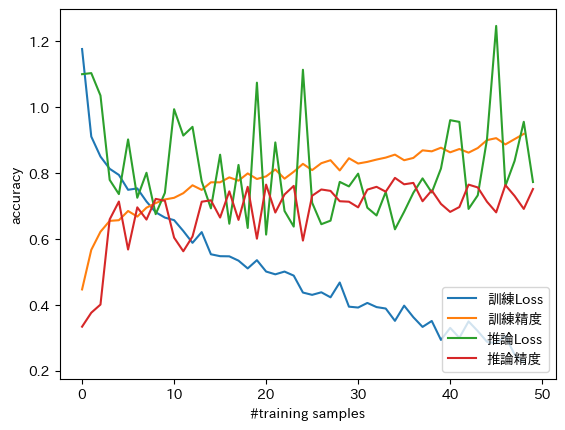

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

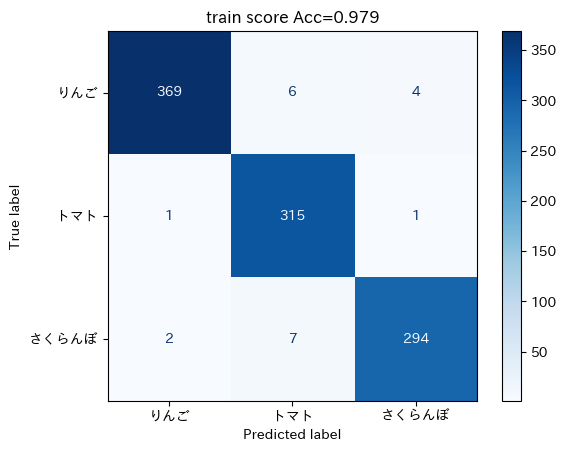

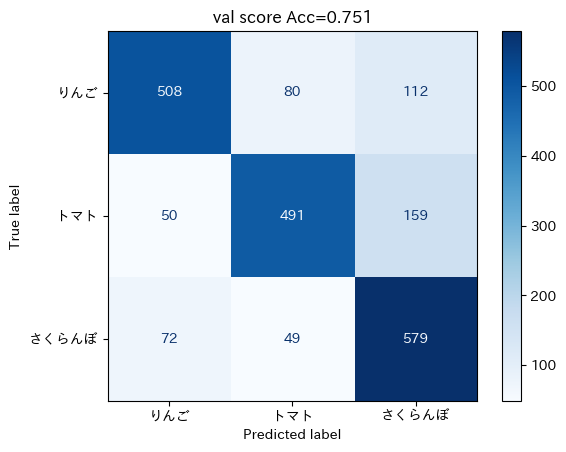

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

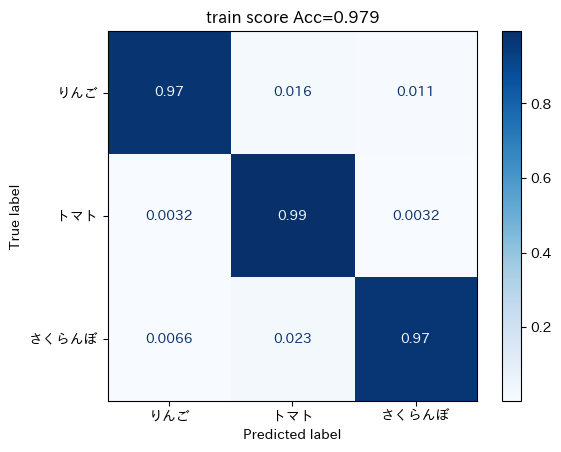

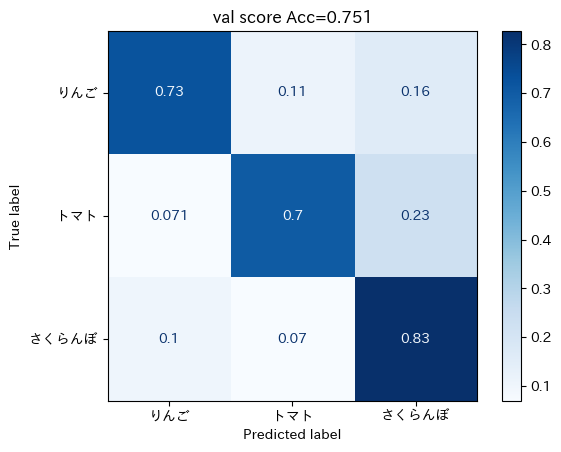

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()